In [ ]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen-2.5-32b")
reviewer_llm = ChatGroq(model="gemma2-9b-it")
#result1=llm.invoke("Hello")
#result2=reviewer_llm.invoke("Hello")
#result1
#result2

AIMessage(content='Hello! 👋 \n\nHow can I help you today? 😊\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 11, 'total_tokens': 27, 'completion_time': 0.029090909, 'prompt_time': 0.001899746, 'queue_time': 0.019476673, 'total_time': 0.030990655}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-d8fe753c-4551-45bc-a10c-6300cfc0d567-0', usage_metadata={'input_tokens': 11, 'output_tokens': 16, 'total_tokens': 27})

In [199]:
from youtube_transcript_api import YouTubeTranscriptApi
from langchain_core.tools import tool

@tool
def yt_video_transcript_extractor(video_id: str) -> str:
    """
    Extracts transcript data from a YouTube video.

    Args:
        video_id (str): The YouTube video ID.

    Returns:
        Document: A LangChain document containing the transcript.
    """

    transcript = YouTubeTranscriptApi.get_transcript(video_id)
    text_content = "\n".join([entry["text"] for entry in transcript])  # Combine transcript
    return text_content


tools = [yt_video_transcript_extractor]
llm_with_tools = llm.bind_tools(tools)


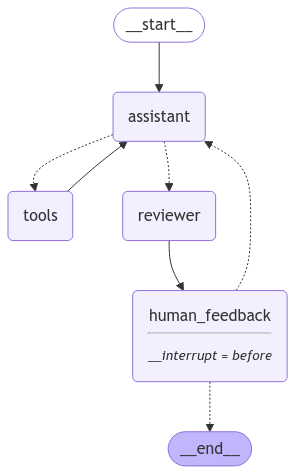

In [ ]:
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

# System message
sys_msg = SystemMessage(content="You are a helpful assistant to review the transcript of youtube video and create a humour blog content which should have less than 500 words")

# Blog Generator Node
def assistant(state: MessagesState):
    transcript = None
    blog = None
    needs_humor_improvement = False  # Track if we need humor improvement

    for msg in state["messages"]:
        if isinstance(msg, AIMessage):
            if "transcript" in msg.content.lower():
                transcript = msg.content
            if "humor improvement" in msg.content.lower():  # Detect if humor needs improvement
                needs_humor_improvement = True
            if "blog" in msg.content.lower():
                blog = msg.content

    if transcript and not needs_humor_improvement:
        # Generate normal blog
        blog_msg = SystemMessage(
            content=f"Write a humorous blog (under 500 words) using this transcript:\n{transcript}"
        )
        return {"messages": [llm_with_tools.invoke([blog_msg])]}

    elif transcript and needs_humor_improvement:
        # Rewrite blog with extra humor
        improve_blog_msg = SystemMessage(
            content=f"Improve the humor in this blog and make it really funny:\n{blog}"
        )
        return {"messages": [llm_with_tools.invoke([improve_blog_msg])]}

    else:
        # If no transcript, fetch it
        return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}


reviewer_msg = SystemMessage(content="You are a helpful assistant to review the blog content of a youtube video. You should rate the blog content based on the humour present in it. Rating should be in the scale of 100.")

# Reviewer Node
def reviewer(state: MessagesState):
   return {"messages": [reviewer_llm.invoke([reviewer_msg] + state["messages"])]}

# Human feedback node
def human_feedback(state: MessagesState):
    return {"messages": state["messages"]}

# Decision function for human feedback
def evaluate_feedback(state: MessagesState) -> str:
    """Use LLM to classify user feedback as 'positive' or 'negative'."""

    last_message = state["messages"][-1].content  # Get last human feedback

    # System message to guide LLM
    classify_msg = SystemMessage(
        content="Analyze the following feedback and classify it strictly as 'positive' or 'negative'. "
                "If the feedback suggests dissatisfaction, humor improvement, or rewriting, classify it as 'negative'. "
                "Otherwise, classify it as 'positive'. Return only 'positive' or 'negative' as output.\n"
                f"Feedback: {last_message}"
    )

    # Ask LLM to classify
    response = llm_with_tools.invoke([classify_msg])

    # Extract LLM's decision and ensure only 'positive' or 'negative' is assigned
    if hasattr(response, 'content') and response.content:
        decision = response.content.strip().lower()
        if decision not in ["positive", "negative"]:  # Fallback if response is unexpected
            decision = "positive"
    else:
        decision = "positive"  # Default if response is None or invalid

    print(f"Decision: {decision}")  # Debugging output

    return "assistant" if decision == "negative" else END  # Continue improving if negative


    

# Tool Node (Handles tool calls)
def tool_node(state: MessagesState):
    # Extract video ID
    video_id = None
    for msg in state["messages"]:
        if isinstance(msg, HumanMessage):
            video_id = msg.content.strip()
            break

    if not video_id:
        return {"messages": state["messages"] + [AIMessage(content="ERROR: No video ID provided.")]}

    try:
        transcript_msg = yt_video_transcript_extractor.invoke({"video_id": video_id})
        return {"messages": state["messages"] + [transcript_msg]}
    except Exception as e:
        return {"messages": state["messages"] + [AIMessage(content=f"ERROR: {str(e)}")]}

# Conditional edge function to route to the appropriate node
def route_decision(state: MessagesState):
    """Determine whether to fetch transcript or write blog"""
    for msg in state["messages"]:
        if "transcript" in msg.content.lower():
            return "reviewer"  # If transcript exists, send for review
    return "tools"  # Else, go get transcript  

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", tool_node)
builder.add_node("reviewer", reviewer)
builder.add_node("human_feedback", human_feedback)

# Define edges: these determine the control flow
builder.add_edge(START, "assistant")
builder.add_edge("tools", "assistant")
builder.add_edge("reviewer", "human_feedback")
builder.add_conditional_edges(
    "assistant",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "tools": "tools",
        "reviewer": "reviewer",
    }
)
builder.add_conditional_edges("human_feedback",evaluate_feedback,["assistant", END])

memory = MemorySaver()
## human in the loop
graph = builder.compile(interrupt_before=["human_feedback"], checkpointer=memory)

# Show
display(Image(graph.get_graph().draw_mermaid_png()))

In [201]:
initial_input={"messages":HumanMessage(content="wVhG59zh4uQ&list=PLA7lNLNvxTzig5dqfGl8DGbLOvUI08yXg&index=4")}

thread={"configurable":{"thread_id":"6"}}

In [202]:
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

wVhG59zh4uQ&list=PLA7lNLNvxTzig5dqfGl8DGbLOvUI08yXg&index=4
================================== Ai Message ==================================
Tool Calls:
  yt_video_transcript_extractor (call_zyfy)
 Call ID: call_zyfy
  Args:
    video_id: wVhG59zh4uQ
================================ Human Message =================================

what's your name uh Ralph wreck-it Ralph
you're not from here are you
no well yeah I mean I mean not from
right in this area I'm just doing some
work here Oh kind of work there's some
routine candy tree trimming uh you
probably want to stand back in fact this
whole area is technically closed while
we're trimming who's we
candy tree Department ah where is
everybody else
oh it's just me today ah you just met
like the Royal we
yep that's right hey are you a hobo no
I'm not a hobo
what's your name uh Ralph wreck-it Ralph
you're not from here are you
no well yeah I mean I mean not fr

In [203]:
state=graph.get_state(thread)
state.next

('human_feedback',)

In [194]:
state

StateSnapshot(values={'messages': [HumanMessage(content='wVhG59zh4uQ&list=PLA7lNLNvxTzig5dqfGl8DGbLOvUI08yXg&index=4', additional_kwargs={}, response_metadata={}, id='8378eb85-1089-4b11-be33-b4c65d23e99c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ya2c', 'function': {'arguments': '{"video_id": "wVhG59zh4uQ"}', 'name': 'yt_video_transcript_extractor'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 255, 'total_tokens': 288, 'completion_time': 0.165, 'prompt_time': 0.01413485, 'queue_time': 0.23654114499999998, 'total_time': 0.17913485}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-c19d0619-8c84-4a17-8cf3-9457a0c3aa9b-0', tool_calls=[{'name': 'yt_video_transcript_extractor', 'args': {'video_id': 'wVhG59zh4uQ'}, 'id': 'call_ya2c', 'type': 'tool_call'}], usage_metadata={'input_tokens': 255, 'output_tokens': 33, 'total_tokens': 28

In [209]:
graph.update_state(thread,{"messages":[HumanMessage(content="Its good but need some dark humour in it")]})

{'configurable': {'thread_id': '6',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff5b8d-0660-6f72-8009-da3556b30959'}}

In [210]:
new_state = graph.get_state(thread).values
for m in new_state['messages']:
    m.pretty_print()

================================ Human Message =================================

wVhG59zh4uQ&list=PLA7lNLNvxTzig5dqfGl8DGbLOvUI08yXg&index=4
================================== Ai Message ==================================
Tool Calls:
  yt_video_transcript_extractor (call_zyfy)
 Call ID: call_zyfy
  Args:
    video_id: wVhG59zh4uQ
================================ Human Message =================================

what's your name uh Ralph wreck-it Ralph
you're not from here are you
no well yeah I mean I mean not from
right in this area I'm just doing some
work here Oh kind of work there's some
routine candy tree trimming uh you
probably want to stand back in fact this
whole area is technically closed while
we're trimming who's we
candy tree Department ah where is
everybody else
oh it's just me today ah you just met
like the Royal we
yep that's right hey are you a hobo no
I'm not a hobo
what's your name uh Ralph wreck-it Ralph
you're not from here are you
no well yeah I mean I mean not fr

In [211]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Its good but need some dark humour in it
Decision: negative
================================ Human Message =================================

Its good but need some dark humour in it
================================== Ai Message ==================================
Tool Calls:
  yt_video_transcript_extractor (call_95th)
 Call ID: call_95th
  Args:
    video_id: dZ7t3b5kK5g
================================== Ai Message ==================================

Okay, I see where you're coming from! Injecting some dark humor into this scene could definitely crank up the laughs for you. 

Here's how we could twist the candy tree trimming scenario to be a bit more darkly comedic:

* **Twisted Motivation:** Instead of routine maintenance, Ralph is actually sabotaging the candy trees, slowly poisoning them with despair and existential dread. He's tired of the sugary sweetness and wants to bring some "real world" problem

In [212]:
state=graph.get_state(thread)
state.next

('human_feedback',)

In [213]:
state

StateSnapshot(values={'messages': [HumanMessage(content='wVhG59zh4uQ&list=PLA7lNLNvxTzig5dqfGl8DGbLOvUI08yXg&index=4', additional_kwargs={}, response_metadata={}, id='20d8dfb1-8595-4a6a-8de0-3296f876fa6c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_zyfy', 'function': {'arguments': '{"video_id": "wVhG59zh4uQ"}', 'name': 'yt_video_transcript_extractor'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 33, 'prompt_tokens': 255, 'total_tokens': 288, 'completion_time': 0.165, 'prompt_time': 0.016382687, 'queue_time': 0.23514914999999997, 'total_time': 0.181382687}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-94b0f495-423c-4968-8209-8ef52a7cfd91-0', tool_calls=[{'name': 'yt_video_transcript_extractor', 'args': {'video_id': 'wVhG59zh4uQ'}, 'id': 'call_zyfy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 255, 'output_tokens': 33, 'total_tokens': 

In [215]:
graph.update_state(thread,{"messages":[HumanMessage(content="Its good now. Thanks")]})

{'configurable': {'thread_id': '6',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff5b9c-7c99-669d-800d-519142c9a027'}}

In [217]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Its good now. Thanks
Decision: positive
================================ Human Message =================================

Its good now. Thanks


In [218]:
state=graph.get_state(thread)
state.next

()